# First look at invariant mass

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

Welcome to JupyROOT 6.26/06
Loaded bin migration and acceptance weights from MC calculations.


## (1) Load data

### (1.1) Load data file

In [2]:
data_path  = "/Users/erezcohen/Desktop/data/CLAS12/RGB/BranchingRatios/sidisdvcs"
subdirname = "sidisdvcs_1Jan2025_commit_5584716" 
data = []
for run,runIdx in zip([6421,6422,6426,6429,6430,6431,6432,6433,6437],range(10)):
# run        = 6164
    filename   = "skimmed_BranchingRatios_sidisdvcs_%06d_eep2gX.csv"%run
    fullfile   = data_path + "/" + subdirname + "/" + filename
    data_run = pd.read_csv(fullfile)
    if runIdx==0: data = data_run
    else: data = pd.concat([data,data_run])
    print('Loaded %dk events from run %d'%(len(data_run)/1000,run))
    
print('Loaded %dk events from %s'%(len(data)/1000,subdirname))

Loaded 383k events from run 6421
Loaded 365k events from run 6422
Loaded 326k events from run 6426
Loaded 407k events from run 6429
Loaded 79k events from run 6430
Loaded 320k events from run 6431
Loaded 398k events from run 6432
Loaded 444k events from run 6433
Loaded 153k events from run 6437
Loaded 2878k events from sidisdvcs_1Jan2025_commit_5584716


### (1.2) Add cuts not previously imposed

Following G. Matousek 
"Measurements of Beam Spin Asymmetries of $\pi^\pm \pi^0$ dihadrons at CLAS12 using Gradient Boosted Trees

https://www.jlab.org/Hall-B/shifts/admin/paper_reviews/2024/PiPi0_AnalysisNote_(3)_3.pdf-7600066-2024-03-09-v1.pdf


1. $E(\gamma_1) > 10$ MeV and $E(\gamma_2) > 10$ MeV,
2. $5^\circ < \theta < 35^\circ$ for all reconstructed particles (forward detector) 
3. $E(PCAL) > 0$
4. PCAL calorimeter coordinates $lv$ and $lw$ within [14,400] cm
5. $0.9 < \beta(\gamma) < 1.1$

In [3]:
Eg_min = 0.0100
data_after_cuts = data[(data["g1_E"]>Eg_min) & (data["g2_E"]>Eg_min)]
print('Retained %dk events after energy cut'%(len(data_after_cuts)/1000))

Theta_min = 5  * 3.14/180.
Theta_max = 35 * 3.14/180.
data_after_cuts = data_after_cuts[  (Theta_min < data_after_cuts["e_Theta"])  & (data_after_cuts["e_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["p_Theta"])  & (data_after_cuts["p_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["g1_Theta"]) & (data_after_cuts["g1_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["g2_Theta"]) & (data_after_cuts["g2_Theta"] < Theta_max) ]
print('Retained %dk events after theta cut'%(len(data_after_cuts)/1000))

EPCAL_min = 0
data_after_cuts = data_after_cuts[(EPCAL_min < data_after_cuts["g1_E_PCAL"]) & (EPCAL_min < data_after_cuts["g2_E_PCAL"])]
print('Retained %dk events after PCAL energy cut'%(len(data_after_cuts)/1000))




PCAL_V_min, PCAL_V_max = 14,400
PCAL_W_min, PCAL_W_max = 14,400
data_after_cuts = data_after_cuts[  (PCAL_V_min < data_after_cuts["g1_PCAL_V"]) & (data_after_cuts["g1_PCAL_V"] < PCAL_V_max)                    
                                  & (PCAL_W_min < data_after_cuts["g1_PCAL_W"]) & (data_after_cuts["g1_PCAL_W"] < PCAL_W_max)
                                  & (PCAL_V_min < data_after_cuts["g2_PCAL_V"]) & (data_after_cuts["g2_PCAL_V"] < PCAL_V_max)                    
                                  & (PCAL_W_min < data_after_cuts["g2_PCAL_W"]) & (data_after_cuts["g2_PCAL_W"] < PCAL_W_max)]
print('Retained %dk events after PCAL coordinates cut'%(len(data_after_cuts)/1000))


beta_min, beta_max = 0.9,1.1
data_after_cuts = data_after_cuts[  (beta_min < data_after_cuts["g1_beta"]) & (data_after_cuts["g1_beta"] < beta_max)                    
                                  & (beta_min < data_after_cuts["g2_beta"]) & (data_after_cuts["g2_beta"] < beta_max)]
print('Retained %dk events after beta(gamma) cut'%(len(data_after_cuts)/1000))

Retained 2287k events after energy cut
Retained 1842k events after theta cut
Retained 880k events after PCAL energy cut
Retained 726k events after PCAL coordinates cut
Retained 657k events after beta(gamma) cut


6. $M_x(\gamma^* d \to p \gamma \gamma) > 0.939$ GeV

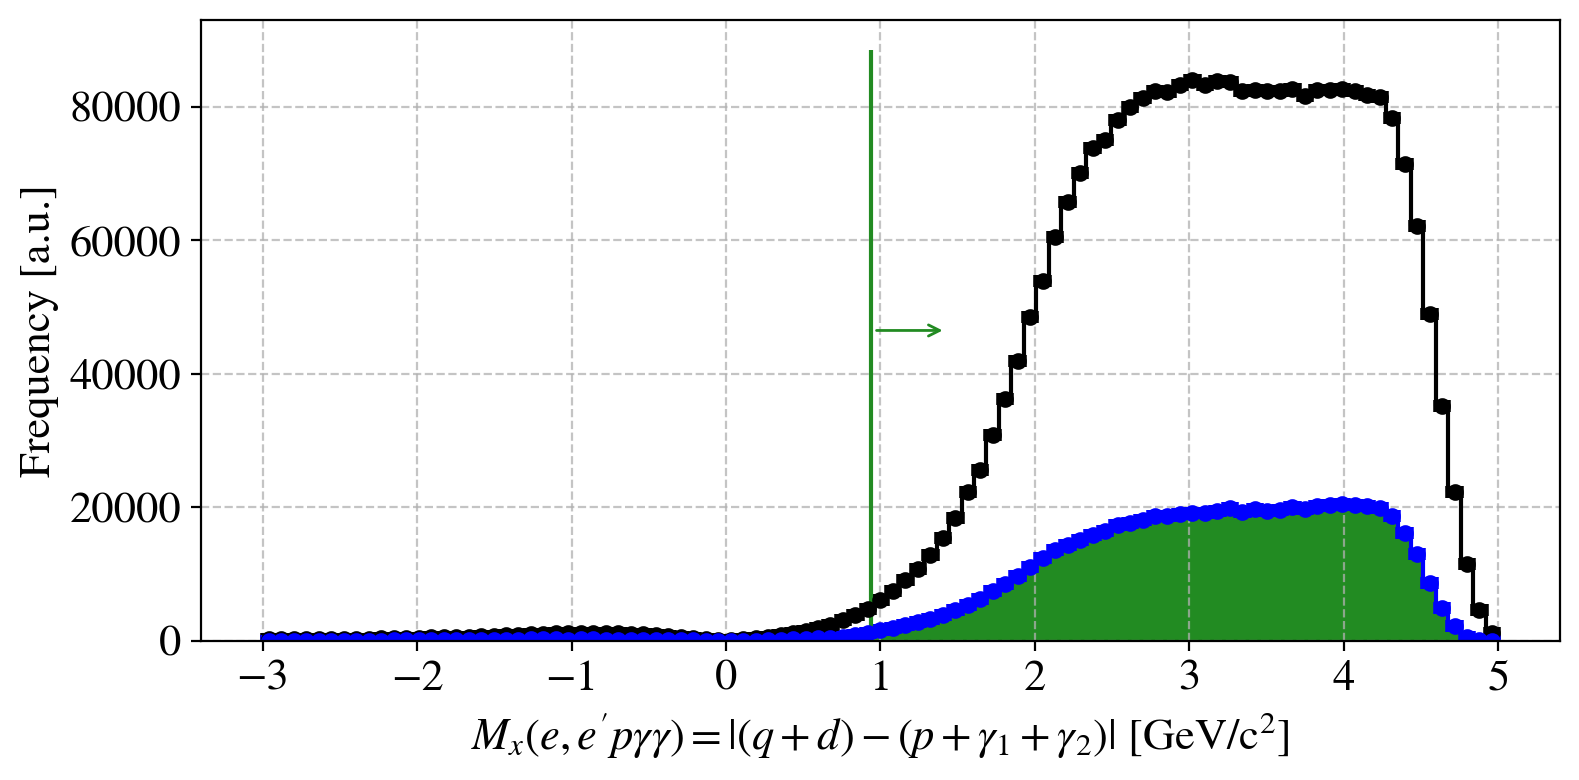

In [4]:
var  = "M_x_deep2g"
bins = np.linspace(-3,5,100); 
Mx_min = 0.939

fig = plt.figure(figsize=(8,4),tight_layout=True)
ax  = fig.add_subplot(1,1,1)

Mx, h_all, _, _ = plot_step_hist(data[var], bins=bins, color='k');
Mx, h_after_cuts, _, _ = plot_step_hist(data_after_cuts[var], bins=bins, color='b');
set_axes(ax,"$M_x(e,e'p\gamma\gamma) = |(q + d) - (p + \gamma_1 + \gamma_2 )| $ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

plt.vlines(Mx_min, 0, np.max(ax.get_ylim()), color='forestgreen');
ax.annotate("", xy=(Mx_min + 0.5, 0.5*np.max(ax.get_ylim())), xytext=(Mx_min, 0.5*np.max(ax.get_ylim())),arrowprops=dict(arrowstyle="->", color='forestgreen'))
idx_v_min = int(np.argwhere( Mx > Mx_min )[0])
plt.bar(Mx[idx_v_min:-1], h_after_cuts[idx_v_min:-1], color='forestgreen', width=(Mx[1] - Mx[0]));

In [5]:
Mx_min = 0.939
data_after_Mx_cuts = data_after_cuts[ Mx_min < data_after_cuts["M_x_deep2g"]]
print('Retained %dk events after Mx cut'%(len(data_after_Mx_cuts)/1000))

Retained 648k events after Mx cut


## (2) Plot distirbution of invariant mass of the two $\gamma$

In [6]:
M_pi  = 0.135
M_eta = 0.547
M_rho = 0.770

In [7]:
bins_Mgg=np.linspace(0,0.8,50)

In [8]:
Eg_min = 1.0 # GeV
data_after_Eg_min_cut = data_after_Mx_cuts[(data_after_Mx_cuts["g1_E"] > Eg_min) & (data_after_Mx_cuts["g2_E"] > Eg_min)]
print('Retained %dk events after Eg > %0.1f cut'%(Eg_min,len(data_after_Eg_min_cut)/1000))

Retained 1k events after Eg > 31.1 cut


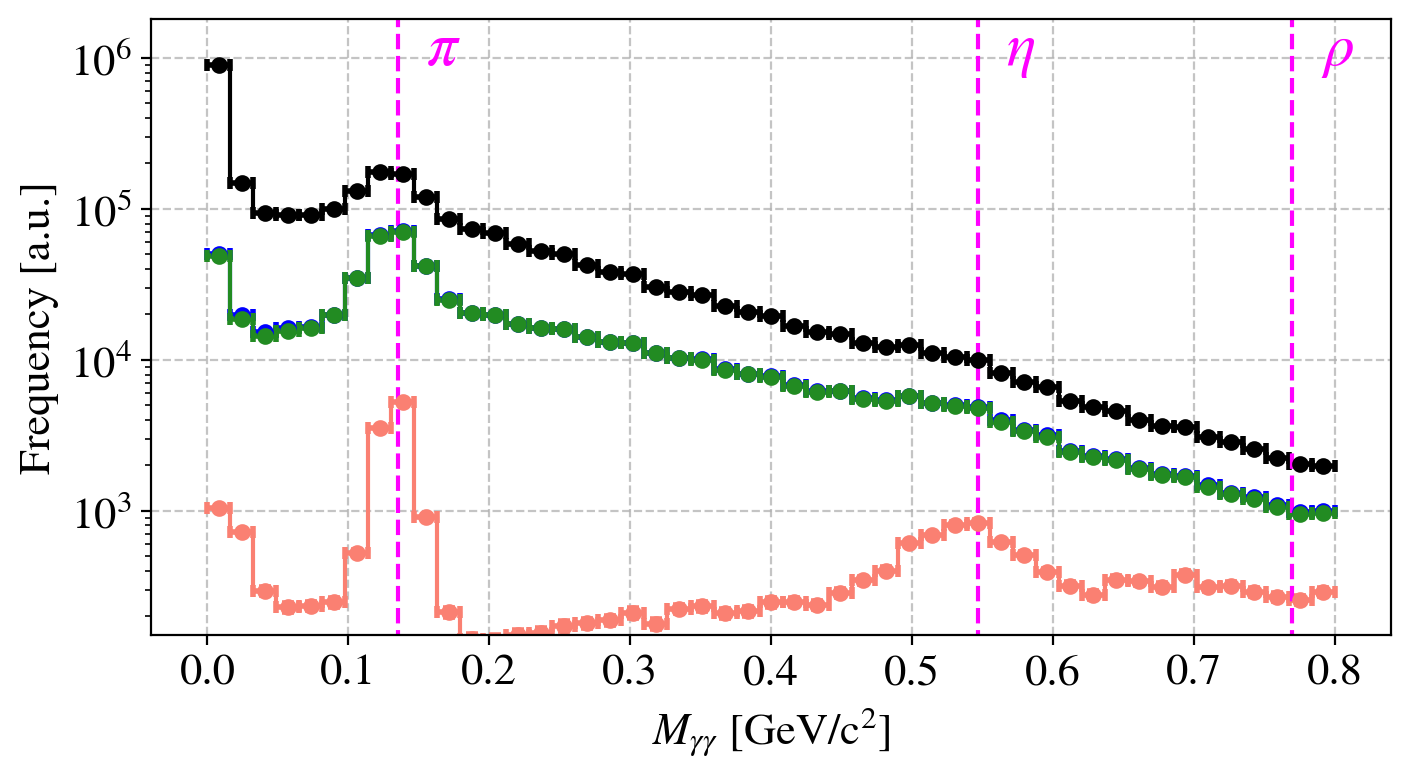

In [9]:
var = "Mgg"
x = data_after_cuts[var]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
h_all  = plot_step_hist(data[var],               bins=bins_Mgg ,color='k');
h_cuts = plot_step_hist(data_after_cuts[var],    bins=bins_Mgg, color='b');
h_Mx_cut = plot_step_hist(data_after_Mx_cuts[var], bins=bins_Mgg, color='forestgreen');
h_Eg_min_cut = plot_step_hist(data_after_Eg_min_cut[var],  bins=bins_Mgg, color='salmon');


ymax = 2*np.max(h_all) # 0.3*np.max(h_all)
for resname,M_res in zip(['\\pi','\\eta','\\rho'],[M_pi,M_eta,M_rho]):
    plt.vlines(M_res, 0,ymax,linestyles='--',colors='magenta');
    plt.text(M_res+0.02,0.5*ymax,"$"+resname+"$",color='magenta',fontsize=22)
set_axes(ax,'$M_{\gamma\gamma}$ [GeV/c$^2$]','Frequency [a.u.]',fontsize=16,do_add_grid=True,ylim=(150,ymax));
ax.set_yscale('log')

## (3) Add a kinematic cut to clean up events?

### (3.1) $E_\gamma > E_\gamma^{min}$

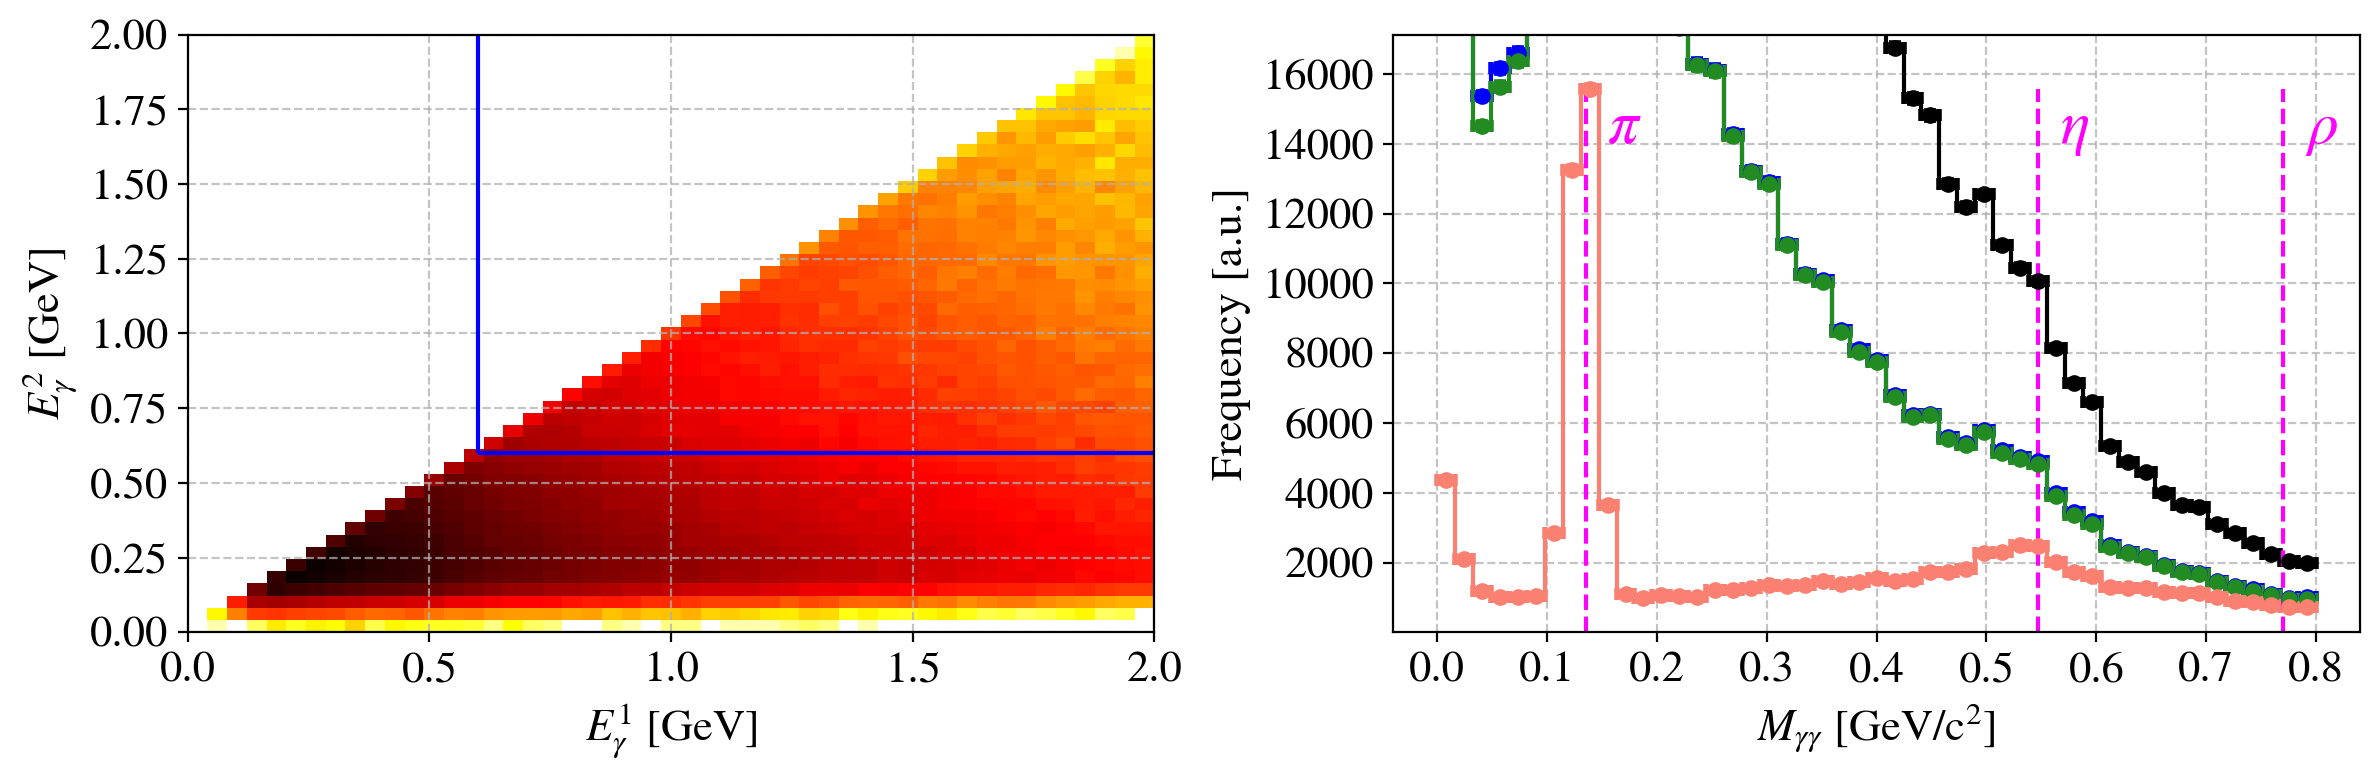

In [10]:
bins_Mgg=np.linspace(0,0.8,50)
Eg_min = 0.6

x = data_after_Mx_cuts["g1_E"]
y = data_after_Mx_cuts["g2_E"]
fig = plt.figure(figsize=(12,4),tight_layout = True)
ax = fig.add_subplot(1,2,1)
plot_2d_hist(x,y,bins=(np.linspace(0,2,50),np.linspace(0,2,50)),ax=ax,norm='log');
set_axes(ax,"$E_\gamma^1$ [GeV]","$E_\gamma^2$ [GeV]",fontsize=16,do_add_grid=True,xticks=(0,0.5,1,1.5,2));
plt.vlines(Eg_min,Eg_min,2,colors='b')
plt.hlines(Eg_min,Eg_min,2,colors='b')
# ax.set_zscale('log')

var = "Mgg"
ax = fig.add_subplot(1,2,2)
h_all = plot_step_hist(data[var],               bins=bins_Mgg ,color='k', label = "(e,e') cuts");
h_Mx = plot_step_hist(data_after_cuts[var],    bins=bins_Mgg ,color='b', label = "additional cuts");
h_cut = plot_step_hist(data_after_Mx_cuts[var], bins=bins_Mgg, color='forestgreen', label = '$M_x$ cut');
data_sliced = data_after_Mx_cuts[(data_after_Mx_cuts["g1_E"] > Eg_min) & (data_after_Mx_cuts["g2_E"] > Eg_min)]
h_sliced = plot_step_hist(data_sliced[var],  bins=bins_Mgg, color='salmon', label = '$E_\gamma > %.1f$ GeV'%Eg_min);
ymax = np.max(h_sliced)

for resname,M_res in zip(['\\pi','\\eta','\\rho'],[M_pi,M_eta,M_rho]):
    plt.vlines(M_res, 0,ymax,linestyles='--',colors='magenta');
    plt.text(M_res+0.02,0.9*ymax,"$"+resname+"$",color='magenta',fontsize=22)

set_axes(ax,'$M_{\gamma\gamma}$ [GeV/c$^2$]','Frequency [a.u.]',fontsize=16,do_add_grid=True, ylim=(5,1.1*ymax), do_add_legend=False,legend_loc=(0.25,0.4));
# ax.legend(bbox_to_anchor=(1.,1.05))
# ax.set_yscale('log')

# (4) Evaluate and subtract background

In [1]:
def extract_Ratio_eta_pi0(Eg_min   = 1.0,  var = "Mgg",
                           bins_Mgg = np.linspace(0,0.8,50),
                           pi0_Mmin = 0.09,
                           pi0_Mmax = 0.18, 
                           eta_Mmin= 0.45, 
                           eta_Mmax= 0.62):
    
    Mgg = (bins_Mgg[1:] + bins_Mgg[:-1])/2

    data_sliced = data_after_Mx_cuts[(data_after_Mx_cuts["g1_E"] > Eg_min) & (data_after_Mx_cuts["g2_E"] > Eg_min)]
    x = data_after_Mx_cuts["g1_E"]
    y = data_after_Mx_cuts["g2_E"]

    h_sliced,_ = np.histogram(data_sliced[var],  bins=bins_Mgg)
    bg_level = np.mean( h_sliced[20:30] )
    h_bkg    = bg_level * np.ones(len(Mgg))
    h_no_bkg = h_sliced - h_bkg

    idx_pi0_Mmin  = int(np.argwhere(Mgg > pi0_Mmin)[0])
    idx_pi0_Mmax  = int(np.argwhere(Mgg > pi0_Mmax)[0])
    idx_eta_Mmin  = int(np.argwhere(Mgg > eta_Mmin)[0])
    idx_eta_Mmax  = int(np.argwhere(Mgg > eta_Mmax)[0])
    N_pi0         = np.sum(h_no_bkg[idx_pi0_Mmin:idx_pi0_Mmax])
    N_pi0_err     = np.sqrt( np.sum(h_no_bkg[idx_pi0_Mmin:idx_pi0_Mmax]) ) 
    N_eta         = np.sum(h_sliced[idx_eta_Mmin:idx_eta_Mmax] - h_bkg[idx_eta_Mmin:idx_eta_Mmax])
    N_eta_err     = np.sqrt( np.sum(h_no_bkg[idx_eta_Mmin:idx_eta_Mmax]) ) 


    if N_pi0>0 and N_eta>0:
        R_eta_pi0    = N_eta/N_pi0
        R_eta_pi0_err= R_eta_pi0 * np.sqrt( np.square(N_eta_err/N_eta) + np.square(N_pi0_err/N_pi0) ) 
    else :
        R_eta_pi0    = 0
        R_eta_pi0_err= 0
    
    results = dict()
    # results['data_sliced'] = data_sliced
    results['bg_level']      = bg_level
    results['Mgg']           = Mgg
    results['h_all']         = h_sliced
    results['h_bkg']         = h_bkg
    results['N_pi0']         = N_pi0
    results['N_pi0_err']     = N_pi0_err
    results['N_eta']         = N_eta
    results['N_eta_err']     = N_eta_err
    results['idx_pi0_Mmin']  = idx_pi0_Mmin
    results['idx_pi0_Mmax']  = idx_pi0_Mmax
    results['idx_eta_Mmin']  = idx_eta_Mmin
    results['idx_eta_Mmax']  = idx_eta_Mmax
    results['R_eta_pi0']     = R_eta_pi0
    results['R_eta_pi0_err'] = R_eta_pi0_err
    
    return results

NameError: name 'np' is not defined

In [14]:
Eg_min   = 1.
pi0_Mmin = 0.09
pi0_Mmax = 0.18
eta_Mmin = 0.45
eta_Mmax = 0.62
            
r = extract_Ratio_eta_pi0(Eg_min   = Eg_min, 
                           bins_Mgg = np.linspace(0,0.8,50),
                           pi0_Mmin = pi0_Mmin,
                           pi0_Mmax = pi0_Mmax, 
                           eta_Mmin = eta_Mmin, 
                           eta_Mmax = eta_Mmax);
# r

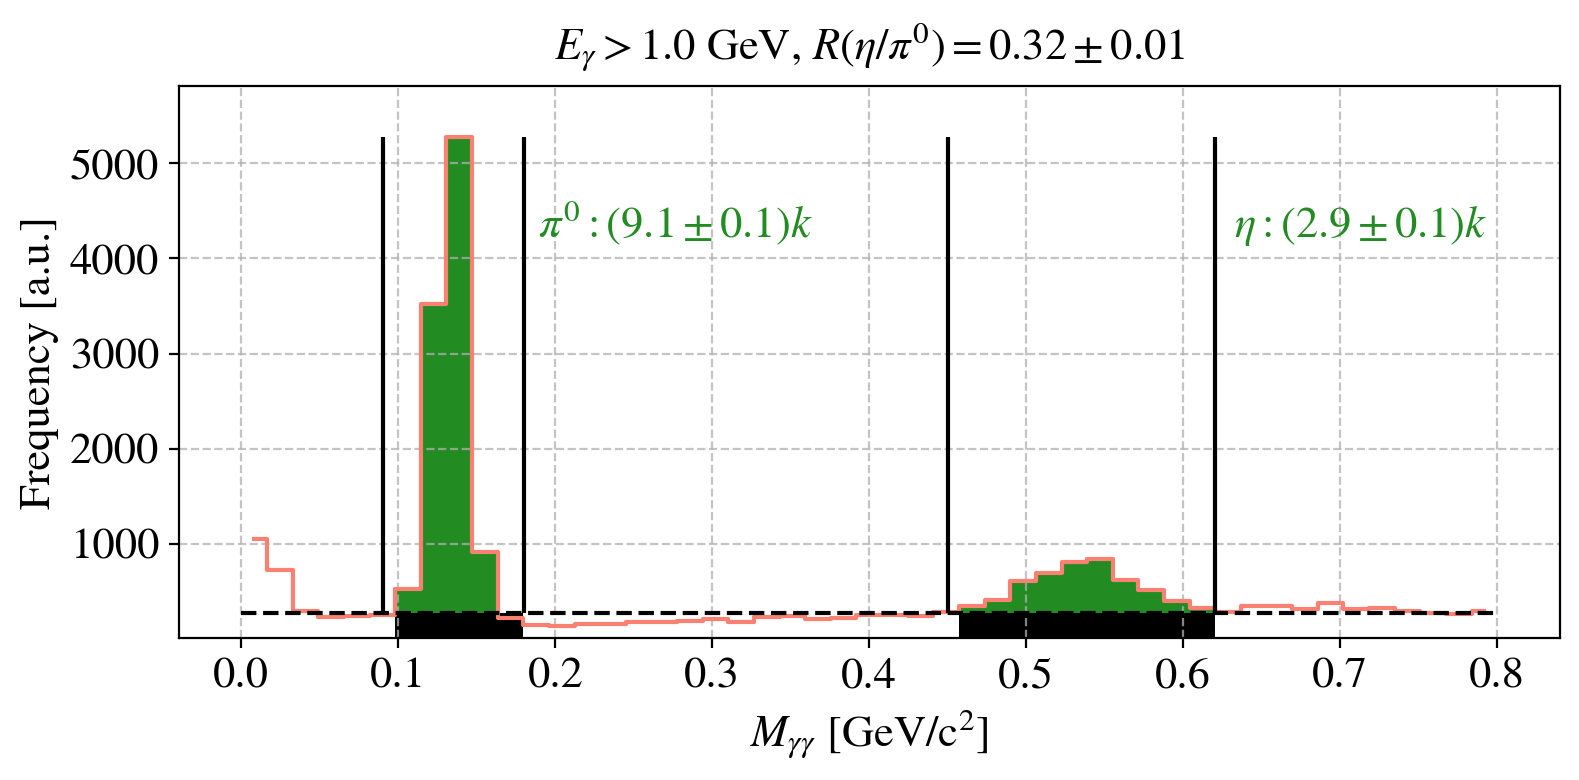

In [15]:
fig = plt.figure(figsize=(8,4),tight_layout = True)
ax = fig.add_subplot(1,1,1)

# Mgg,h_sliced,_,_ = plot_step_hist(data_sliced[var],  bins=bins_Mgg, color='salmon', label = '$E_\gamma > %.1f$ GeV'%Eg_min);
plt.step(r['Mgg'], r['h_all'], where='mid', color='salmon')
ymax = np.max(r['h_all'])

plt.hlines(r['bg_level'],0,0.8,color='black',linestyle='--');
plt.vlines([pi0_Mmin, pi0_Mmax],r['bg_level'],ymax,color='black',linestyle='-');
plt.vlines([eta_Mmin,eta_Mmax],r['bg_level'],ymax,color='black',linestyle='-');

width=(r['Mgg'][1] - r['Mgg'][0])
plt.bar(r['Mgg'][r['idx_pi0_Mmin']:r['idx_pi0_Mmax']],   r['h_all'][r['idx_pi0_Mmin']:r['idx_pi0_Mmax']],    color='forestgreen', width=width);
plt.bar(r['Mgg'][r['idx_eta_Mmin']:r['idx_eta_Mmax']], r['h_all'][r['idx_eta_Mmin']:r['idx_eta_Mmax']],  color='forestgreen', width=width);
plt.bar(r['Mgg'][r['idx_pi0_Mmin']:r['idx_pi0_Mmax']],   r['h_bkg'][r['idx_pi0_Mmin']:r['idx_pi0_Mmax']],       color='k',           width=width);
plt.bar(r['Mgg'][r['idx_eta_Mmin']:r['idx_eta_Mmax']], r['h_bkg'][r['idx_eta_Mmin']:r['idx_eta_Mmax']],     color='k',           width=width);
plt.text( 1.05*pi0_Mmax, 0.8*ymax, "$ \\pi^0: (%.1f\pm %.1f)k$"%(r['N_pi0']*1e-3, r['N_pi0_err']*1e-3),  fontsize=16, color='forestgreen' )
plt.text( 1.02*eta_Mmax, 0.8*ymax, "$\\eta: (%.1f\pm %.1f)k$"%(r['N_eta']*1e-3, r['N_eta_err']*1e-3), fontsize=16, color='forestgreen' )


set_axes(ax,'$M_{\gamma\gamma}$ [GeV/c$^2$]','Frequency [a.u.]',
         title="$E_\gamma > %.1f$ GeV, $R(\\eta/\\pi^0) =%.2f\pm %.2f$"%(Eg_min, r['R_eta_pi0'], r['R_eta_pi0_err']),
         fontsize=16,do_add_grid=True, ylim=(5,1.1*ymax), do_add_legend=False,legend_loc=(0.25,0.4));

In [16]:
Eg_min_arr = np.linspace(0.1,3.2,66)
R,R_err = [],[]
for Eg_min in Eg_min_arr:
    r = extract_Ratio_eta_pi0(Eg_min   = Eg_min, 
                           bins_Mgg = np.linspace(0,0.8,50),
                           pi0_Mmin = pi0_Mmin,
                           pi0_Mmax = pi0_Mmax, 
                           eta_Mmin = eta_Mmin, 
                           eta_Mmax = eta_Mmax);
    R.append(r['R_eta_pi0'])
    R_err.append(r['R_eta_pi0_err'])
    
R = np.array(R)    
R_err = np.array(R_err)
print('Done')    

/var/folders/b4/rpy8fcnx1yx951cj3jxv3cm80000gn/T/ipykernel_24021/4010901952.py:26: RuntimeWarning: invalid value encountered in sqrt
  N_eta_err     = np.sqrt( np.sum(h_no_bkg[idx_eta_Mmin:idx_eta_Mmax]) )


Done


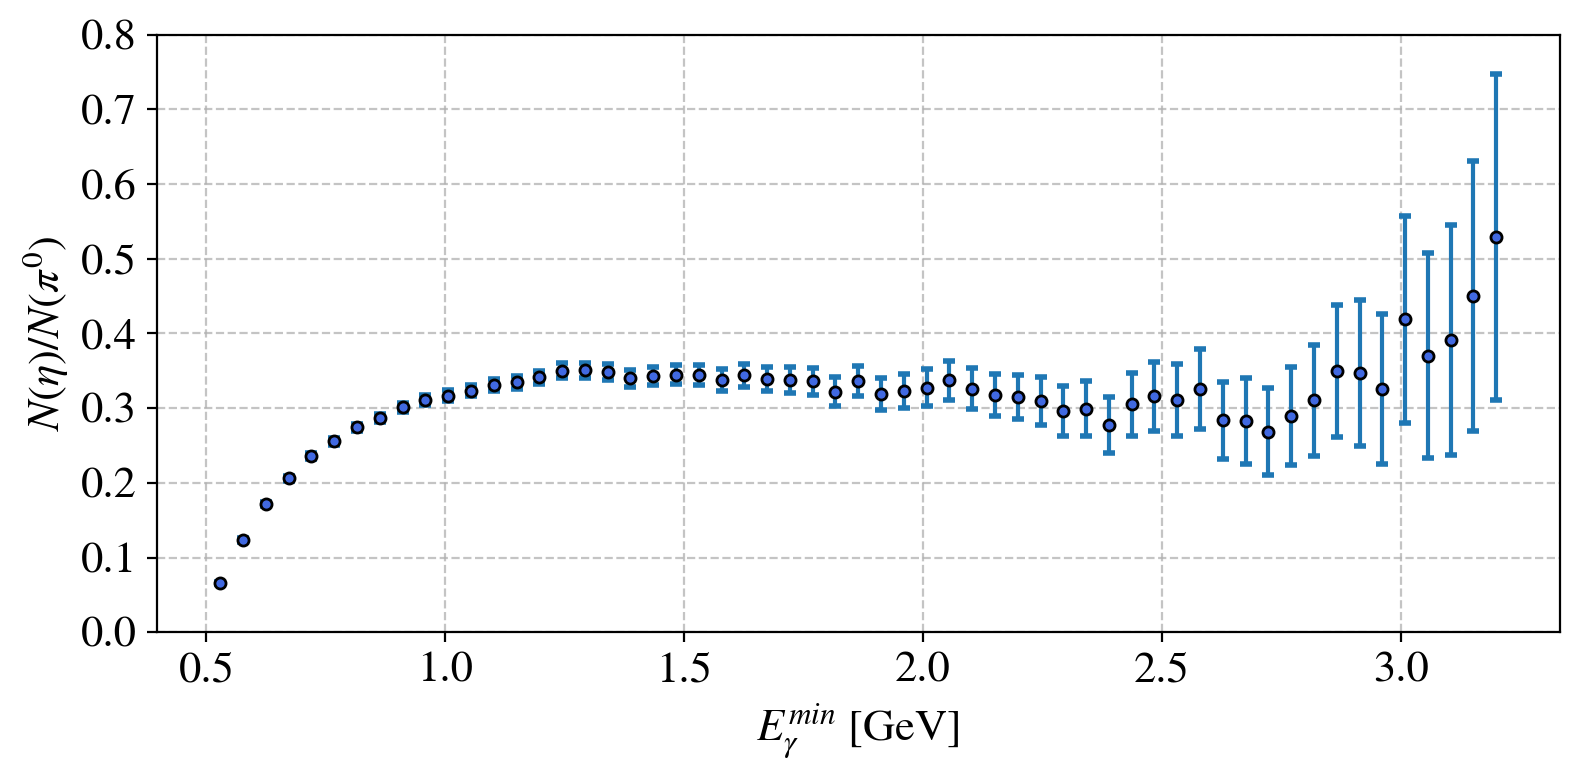

In [17]:
fig = plt.figure(figsize=(8,4),tight_layout = True)
ax = fig.add_subplot(1,1,1)
plt.errorbar(Eg_min_arr[R>0], R[R>0], R_err[R>0], marker='o', markersize=4,capsize=2, capthick=2, 
             markerfacecolor='royalblue', markeredgecolor='k' , linestyle='None')

set_axes(ax,'$E_{\gamma}^{min}$ [GeV]','$N(\\eta)/N(\\pi^0)$',
         fontsize=16,do_add_grid=True, ylim=(0,0.8));

In [18]:
Eg_min = 1.2 # GeV
data_after_Eg_min_cut = data_after_Mx_cuts[(data_after_Mx_cuts["g1_E"] > Eg_min) & (data_after_Mx_cuts["g2_E"] > Eg_min)]
print('Retained %dk events after Eg > %0.1f cut'%(len(data_after_Eg_min_cut)/1000,Eg_min))# Eg_min_arr

Retained 17k events after Eg > 1.2 cut


### (3.2) Missing mass of the $(e,e'p2\gamma)$ reaction

In [37]:
Mx_min = 0.8
data_after_Mx_cuts = data_after_cuts[ Mx_min < data_after_cuts["M_x_deep2g"]]
print('Retained %dk events after Mx cut'%(len(data_after_Mx_cuts)/1000))

Eg_min = 1.2 # GeV
data_after_Eg_min_cut = data_after_Mx_cuts[(data_after_Mx_cuts["g1_E"] > Eg_min) & (data_after_Mx_cuts["g2_E"] > Eg_min)]
print('Retained %dk events after Eg > %0.1f cut'%(Eg_min,len(data_after_Eg_min_cut)/1000))

data_after_h_Mgg_pi0_cut = data_after_Eg_min_cut[(pi0_Mmin < data_after_Eg_min_cut["Mgg"]) & (data_after_Eg_min_cut["Mgg"] < pi0_Mmax)]


Retained 650k events after Mx cut
Retained 1k events after Eg > 17.7 cut


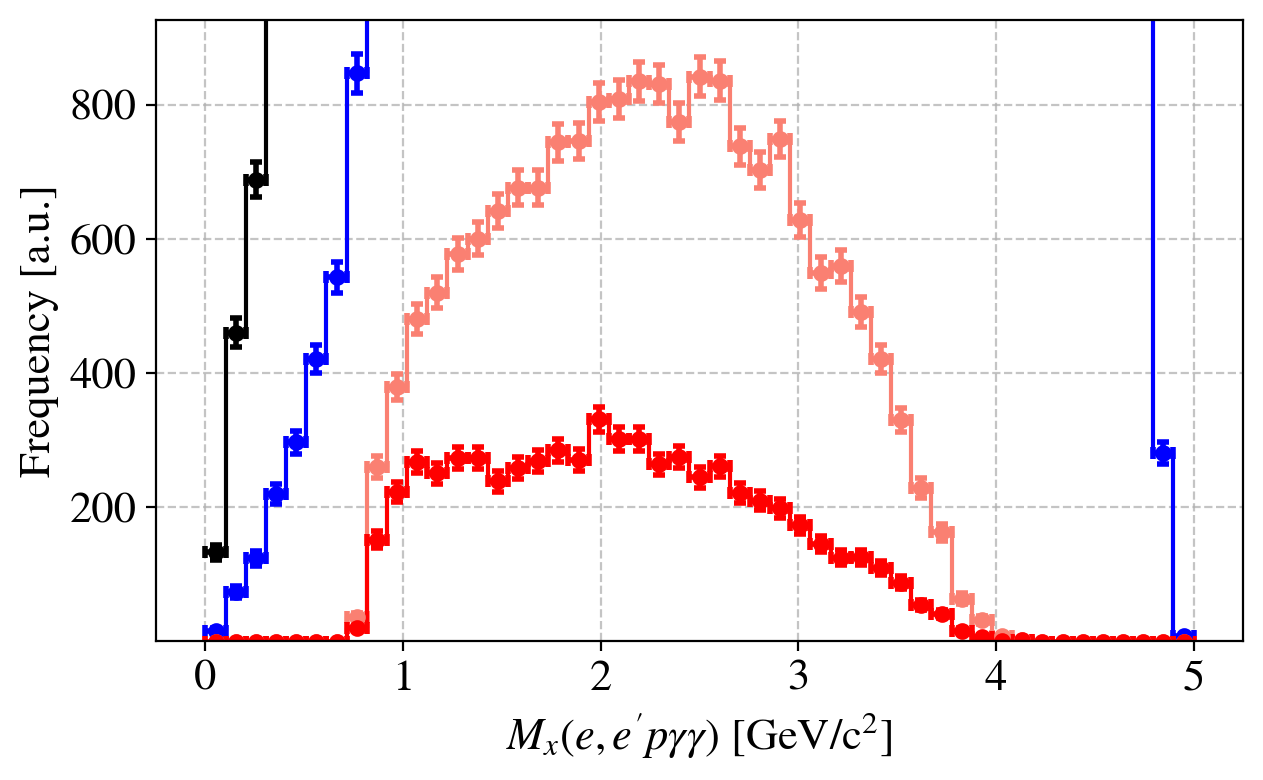

In [40]:
var = "M_x_deep2g"
bins=np.linspace(0,5,50)

fig = plt.figure(figsize=(12,4),tight_layout=True)
ax = fig.add_subplot(1,2,1)
h = plot_step_hist(data[var],bins=bins);
h = plot_step_hist(data_after_cuts[var],bins=bins,color='b');
h_Eg_min_cut = plot_step_hist(data_after_Eg_min_cut[var],  bins=bins, color='salmon');


h_Mgg_pi0 = plot_step_hist(data_after_h_Mgg_pi0_cut[var],  bins=bins, color='red');

set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True,ylim=(1,1.1*np.max(h_Eg_min_cut)));
var_min = 0.940
# ax.set_yscale('log')
# h = plot_step_hist(x[x>var_min],bins=np.linspace(-3,5,100),color='forestgreen');


# data_sliced = data_after_cuts[data_after_cuts[var] > var_min]
# var = "Mgg"
# ax = fig.add_subplot(1,2,2)
# h_all = plot_step_hist(data[var],            bins=bins_Mgg ,color='k');
# h_cut = plot_step_hist(data_after_cuts[var], bins=bins_Mgg, color='b');
# h_sliced = plot_step_hist(data_sliced[var],  bins=bins_Mgg, color='forestgreen');
# ymax = np.max(h_cut)
# set_axes(ax,'$M_{\gamma\gamma}$ [GeV/c$^2$]','Frequency [a.u.]',fontsize=16,do_add_grid=True, ylim=(5,1.1*ymax));
# ax.set_yscale('log')

### (3...) Energy and momentum transfer

In [ ]:
var = "omega"
x = data_after_cuts[var]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
h = plot_step_hist(x,bins=np.linspace(0,10,50));
set_axes(ax,"$\omega$ [GeV]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "q"
x = data_after_cuts[var]
ax = fig.add_subplot(1,2,2)
h = plot_step_hist(x,bins=np.linspace(0,10,50));
set_axes(ax,"$q$ [GeV]",'',fontsize=16,do_add_grid=True);

In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)

var = "p_P"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,1)
h = plot_step_hist(x,bins=np.linspace(0,6,50));
set_axes(ax,"$p_p$ [GeV/c]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "p_Theta"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(1,3,2)
h = plot_step_hist(x,bins=np.linspace(0,50,50));
set_axes(ax,"$\\theta_p$ [deg.]",'',fontsize=16,do_add_grid=True);

var = "p_Phi"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(1,3,3)
h = plot_step_hist(x,bins=np.linspace(-180,180,50));
set_axes(ax,"$\phi_p$ [deg.]",'',fontsize=16,do_add_grid=True);

In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)

var = "p_DC_Chi2N"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,1)
h = plot_step_hist(x,bins=np.linspace(0,20,50));
set_axes(ax,"$\chi^2_p/NDF$ [GeV/c]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "p_Vz"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,2)
h = plot_step_hist(x,bins=np.linspace(-15,10,50));
set_axes(ax,"$V_p(z)$ [cm]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "p_DC_sector"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,3)
h = plot_discrete_histogram(x);
set_axes(ax,"$p$ DC sector",'Frequency [a.u.]',fontsize=16,do_add_grid=True);



In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)

var = "Q2"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,1)
h = plot_step_hist(x,bins=np.linspace(0,8,50));
set_axes(ax,"$Q^2$ [(GeV/c)$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "xB"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,2)
h = plot_step_hist(x,bins=np.linspace(0,1,50));
set_axes(ax,"$x_B$",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "W"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,3)
h = plot_step_hist(x,bins=np.linspace(0,5,50));
set_axes(ax,"$W$ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);


In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)

var = "g1_Theta"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(2,3,1)
h = plot_step_hist(x,bins=np.linspace(0,50,50));
set_axes(ax,"g1_Theta",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "g1_Phi"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(2,3,2)
h = plot_step_hist(x,bins=np.linspace(-180,180,50));
set_axes(ax,"g1_Phi",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "g1_Vz"
x = data_after_cuts[var]
ax = fig.add_subplot(2,3,3)
h = plot_step_hist(x,bins=np.linspace(-15,10,50));
set_axes(ax,"g1_Vz",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "g2_Theta"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(2,3,4)
h = plot_step_hist(x,bins=np.linspace(0,50,50));
set_axes(ax,"g2_Theta",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "g2_Phi"
x = data_after_cuts[var]*180./3.14
ax = fig.add_subplot(2,3,5)
h = plot_step_hist(x,bins=np.linspace(-180,180,50));
set_axes(ax,"g2_Phi",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "g2_Vz"
x = data_after_cuts[var]
ax = fig.add_subplot(2,3,6)
h = plot_step_hist(x,bins=np.linspace(-15,10,50));
set_axes(ax,"g2_Vz",'Frequency [a.u.]',fontsize=16,do_add_grid=True);



In [ ]:
# np.max(data_after_cuts["g1_E_CN"])
# data["g1_E_EC"][1:]
# data[data.evnum==10669]['g1_E_EC']

In [ ]:
fig = plt.figure(figsize=(12,8),tight_layout=True)

for var,bins,i in zip(["g1_E_EC","g1_E_CN","g2_E_EC","g2_E_CN"],[np.linspace(0,1,50),np.linspace(0,100,50),np.linspace(0,1,50),np.linspace(0,100,50)],[1,2,3,4]):
    x = data_after_cuts[var]
    ax = fig.add_subplot(2,2,i)
    h = plot_step_hist(x,bins=bins);
    set_axes(ax,var,'Frequency [a.u.]',fontsize=16,do_add_grid=True);


In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)
ax = fig.add_subplot(1,2,1)
x = data_after_cuts["g1_E_EC"]
y = data_after_cuts["g1_E"]
bins = (np.linspace(0,1,50),np.linspace(0,3,50))
plot_2d_hist(x,y, bins=bins,ax=ax);
set_axes(ax,'g1_E_EC','g1_E',fontsize=16,do_add_grid=True);

ax = fig.add_subplot(1,2,2)
x = data_after_cuts["g2_E_EC"]
y = data_after_cuts["g2_E"]
bins = (np.linspace(0,0.2,50),np.linspace(0,0.8,50))
plot_2d_hist(x,y, bins=bins,ax=ax);
set_axes(ax,'g2_E_EC','g2_E',fontsize=16,do_add_grid=True);

In [ ]:
fig = plt.figure(figsize=(16,4),tight_layout=True)

var = "M_x_peep"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,1)
h = plot_step_hist(x,bins=np.linspace(-2,4,50));
set_axes(ax,"$M_x(p(e,e'p))$ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "M_x_deep"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,2)
h = plot_step_hist(x,bins=np.linspace(0,6,50));
set_axes(ax,"$M_x(d(e,e'p))$ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);

var = "M_x_deep2g"
x = data_after_cuts[var]
ax = fig.add_subplot(1,3,3)
h = plot_step_hist(x,bins=np.linspace(-5,5,50));
set_axes(ax,"$M_x(d(e,e'p\gamma\gamma))$ [GeV/c$^2$]",'Frequency [a.u.]',fontsize=16,do_add_grid=True);
